In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, make_scorer, classification_report
from tensorflow.keras.utils import get_file
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [ ]:
# Load dataset
path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
df = pd.read_csv(path, header=None)
df.columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]


2144903/2144903 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Preprocess data

# Checkng for DUPLICATE values
df.drop_duplicates(keep='first', inplace = True)

# For now, just drop NA's (rows with missing values)
df.dropna(inplace=True,axis=1)

# Convert categorical features to numeric
df["protocol_type"] = df["protocol_type"].astype('category').cat.codes
df["service"] = df["service"].astype('category').cat.codes
df["flag"] = df["flag"].astype('category').cat.codes

# Binary classification: 'normal.' vs 'attack'
#df["label"] = df["label"].apply(lambda x: 0 if x == "normal." else 1)

df["label"] = df["label"].astype('category').cat.codes

# Split data into features and labels
X = df.drop(columns=["label"])
y = df["label"]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

DECISION TREE

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Results:
Fit_time: Mean = 0.66759, Std = 0.07495
Score_time: Mean = 0.03314, Std = 0.00069
Test_accuracy: Mean = 0.99830, Std = 0.00022
Test_precision: Mean = 0.99828, Std = 0.00020
Test_recall: Mean = 0.99830, Std = 0.00022
Test_f1: Mean = 0.99827, Std = 0.00021


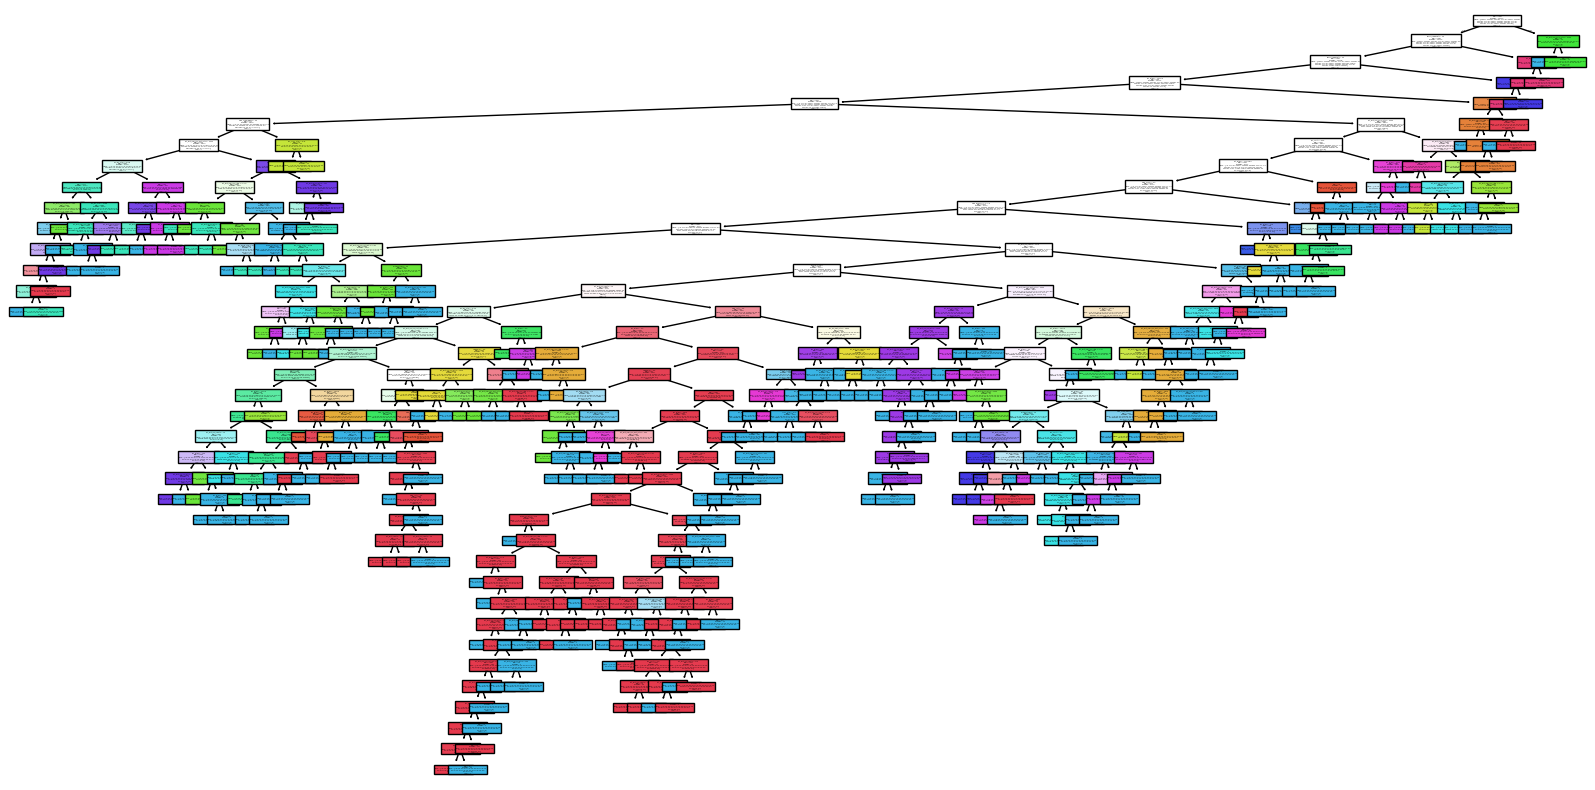

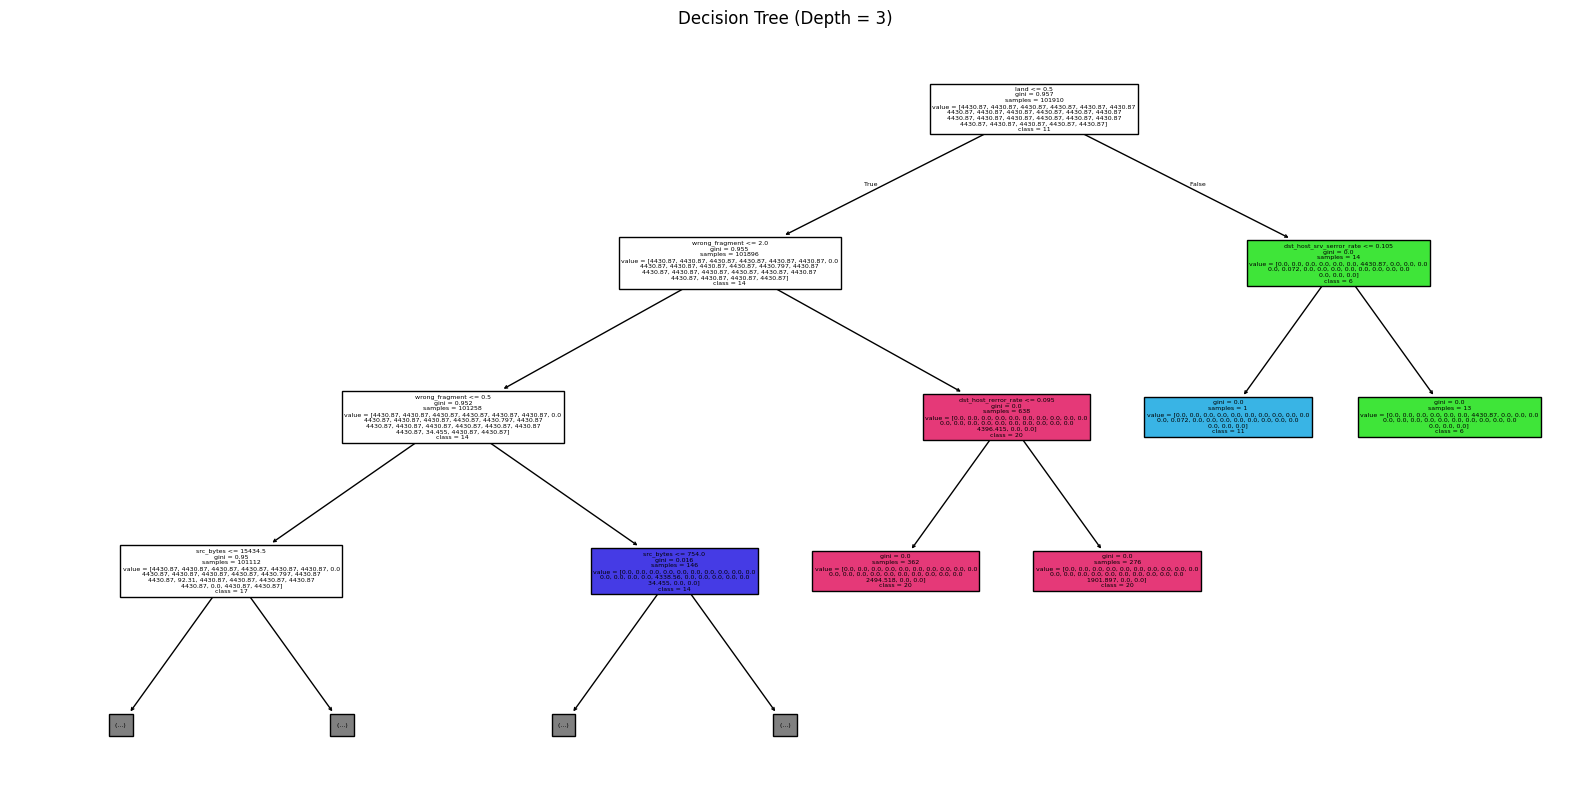


Confusion Matrix:
[[  288     0     0     0     0     0     0     0     0     0     0     2
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     6     0     0     0     0     0     0     2     1     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     1     0     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0    15     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     1     2     0     0     0     0     1     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0   191     0     0     0     0     0     2
      0     0     0     1     0     1     0     0     0     0     0]
 [    0     0     0     0     0     0     6     0     0     0     0     0
      0     0     0     0     0     0     0     0

In [ ]:
#Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, class_weight="balanced")
dt_model.fit(X_train, y_train)

# Scoring metrics for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted'),
    #'roc_auc': make_scorer(multiclass_roc_auc_score, needs_proba=True)
}

# Perform 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(dt_model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)

# Print cross-validation results
print("Cross-Validation Results:")
for metric, values in cv_results.items():
    print(f"{metric.capitalize()}: Mean = {np.mean(values):.5f}, Std = {np.std(values):.5f}")

# Predict on the test set
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]

# Print decision tree
#print("\nDecision Tree Rules:")
#print(export_text(dt_model, feature_names=list(X.columns)))

class_names = [str(c) for c in df["label"].astype('category').cat.categories]
y_test_binarized = label_binarize(y_test, classes=range(len(class_names)))

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X.columns, class_names=class_names, filled=True)
plt.show()

# Visualize the decision tree up to depth 3
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X.columns, class_names=class_names, filled=True, max_depth=3)
plt.title("Decision Tree (Depth = 3)")
plt.show()

# Calculate and print metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
#roc_auc = multiclass_roc_auc_score(y_test, y_pred_proba)
#roc_auc = roc_auc_score(y_test_binarized, dt_model.predict_proba(X_test), multi_class="ovr")

print("\nConfusion Matrix:")
print(conf_matrix)

print(f"\nAccuracy: {accuracy:.5f}")
print(f"F1 Score: {f1:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
#print(f"ROC-AUC Score: {roc_auc:.5f}")
#print(f"ROC-AUC (Multi-Class): {roc_auc:.5f}")
print(y_test)
if len(np.unique(y_test)) == 1:
    print("ROC-AUC cannot be calculated as only one class is present in y_test.")
else:
    y_test_binarized = label_binarize(y_test, classes=range(len(class_names)))
    roc_auc = roc_auc_score(y_test_binarized, dt_model.predict_proba(X_test), multi_class="ovr")
    print(f"\nROC-AUC (Multi-Class): {roc_auc:.5f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

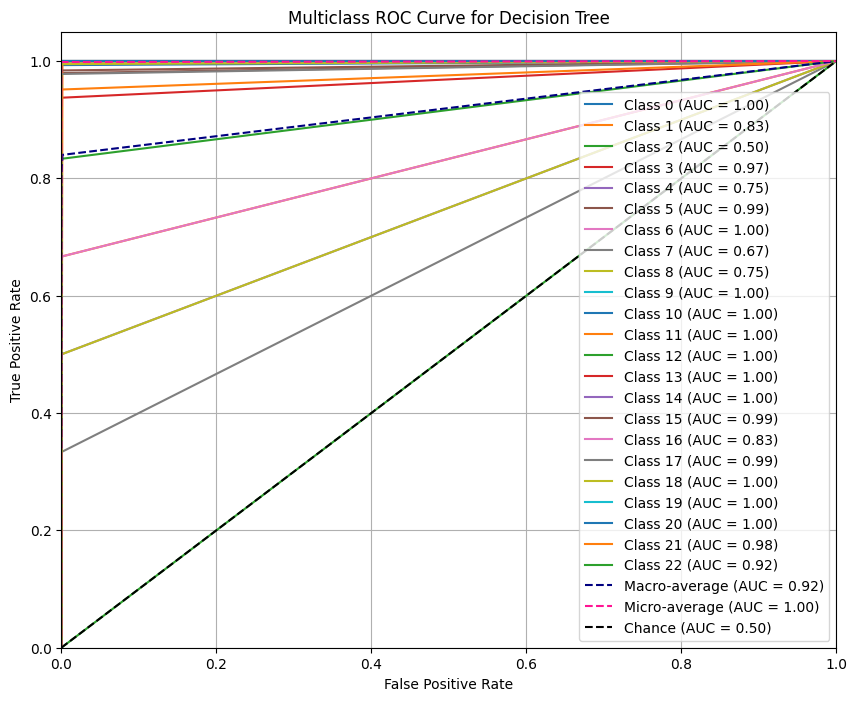

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the test labels for ROC computation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Get prediction probabilities
y_score = dt_model.predict_proba(X_test)

# Initialize ROC metrics
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot individual class ROC curves
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label=f"Macro-average (AUC = {roc_auc['macro']:.2f})",
         linestyle="--", color="navy")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average (AUC = {roc_auc['micro']:.2f})",
         linestyle="--", color="deeppink")

# Plot settings
plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.50)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve for Decision Tree")
plt.legend(loc="lower right")
plt.grid()
plt.show()


RANDOM FOREST

In [ ]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

# Scoring metrics for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted'),
}

# Perform 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(rf_model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)

# Print cross-validation results
print("Cross-Validation Results:")
for metric, values in cv_results.items():
    print(f"{metric.capitalize()}: Mean = {np.mean(values):.5f}, Std = {np.std(values):.5f}")

y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

class_names = [str(c) for c in df["label"].astype('category').cat.categories]
y_test_binarized = label_binarize(y_test, classes=range(len(class_names)))

# Calculate and print metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

print("\nConfusion Matrix:")
print(conf_matrix)

print(f"\nAccuracy: {accuracy:.5f}")
print(f"F1 Score: {f1:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")

print(y_test)
if len(np.unique(y_test)) == 1:
    print("ROC-AUC cannot be calculated as only one class is present in y_test.")
else:
    y_test_binarized = label_binarize(y_test, classes=range(len(class_names)))
    roc_auc = roc_auc_score(y_test_binarized, rf_model.predict_proba(X_test), multi_class="ovr")
    print(f"\nROC-AUC (Multi-Class): {roc_auc:.5f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Results:
Fit_time: Mean = 8.89304, Std = 0.74172
Score_time: Mean = 0.42697, Std = 0.10294
Test_accuracy: Mean = 0.99892, Std = 0.00012
Test_precision: Mean = 0.99865, Std = 0.00010
Test_recall: Mean = 0.99892, Std = 0.00012
Test_f1: Mean = 0.99876, Std = 0.00012

Confusion Matrix:
[[  289     0     0     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     6     0     0     0     0     0     0     0     0     0     3
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     2
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0    16     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     3     0     0     0     0     1     0     0
      0     0     0     0     0     0     0     0     

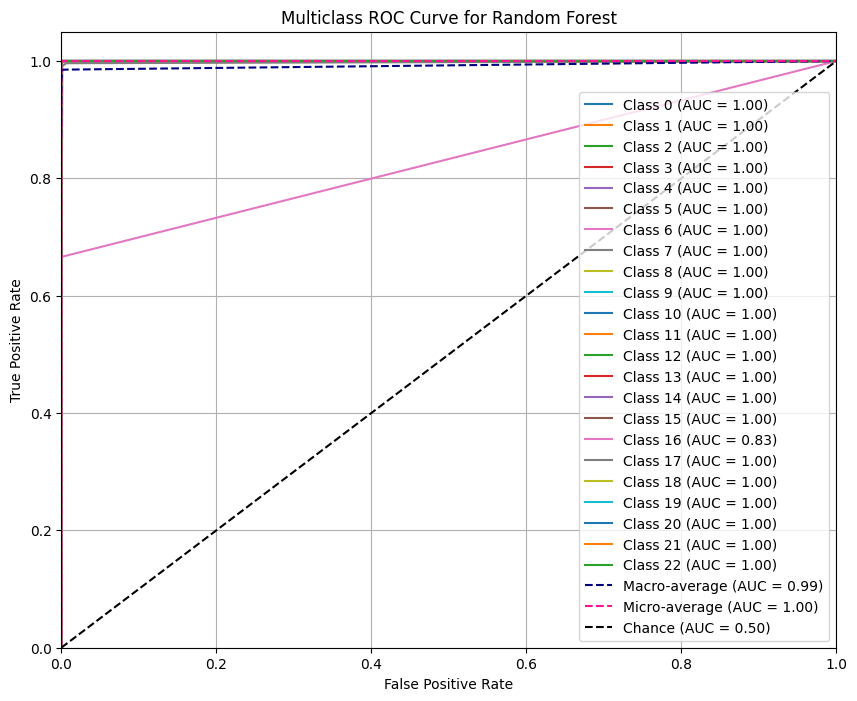

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the test labels for ROC computation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Get prediction probabilities
y_score = rf_model.predict_proba(X_test)

# Initialize ROC metrics
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot individual class ROC curves
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label=f"Macro-average (AUC = {roc_auc['macro']:.2f})",
         linestyle="--", color="navy")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average (AUC = {roc_auc['micro']:.2f})",
         linestyle="--", color="deeppink")

# Plot settings
plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.50)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve for Random Forest")
plt.legend(loc="lower right")
plt.grid()
plt.show()
